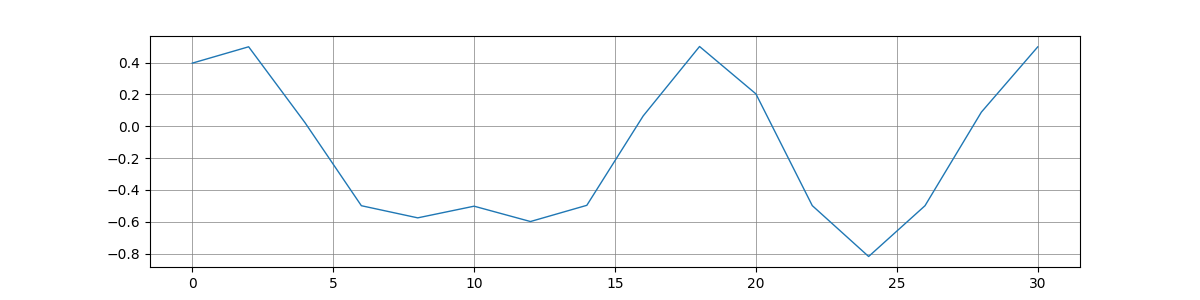

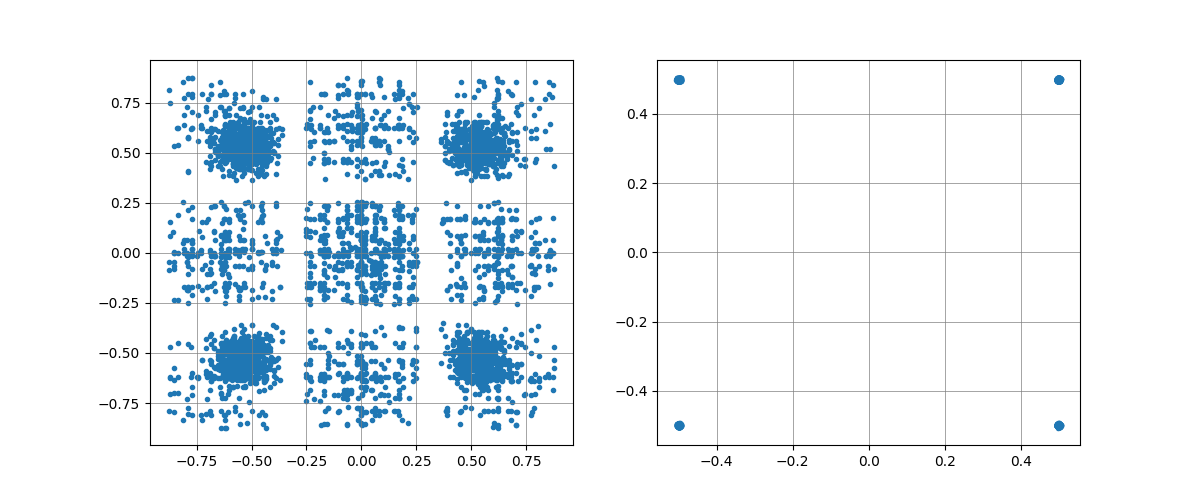

In [3]:
# Выделение тактов из qam-сигнала методом возведения в квадрат
# Если сигнал циклостационарен (PAM, QAM, + Raised Cosine), то
# его возведение в квадрат дает периодическую функцию с периодом одного такта

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.signal import resample_poly
%matplotlib widget

plt.rcParams.update({
        "grid.color": "0.5",    # gray gridlines
        "grid.linestyle": "-",  # solid gridlines
        "grid.linewidth": 0.5,  # thin gridlines
        "lines.linewidth": 1,
        "savefig.dpi": 300,     # higher resolution output.
})


# Символьный источник сигнала QAM-4
N_samples = 2000
rng = np.random.default_rng()
symb_r = rng.integers(2, size=N_samples)
symb_i = rng.integers(2, size=N_samples)
np.putmask(symb_r, symb_r == 0, -1)
np.putmask(symb_i, symb_i == 0, -1)
symb = symb_r + 1j*symb_i

# Ресэмплинг до 2B путем вставки 0
symb_z = np.zeros((N_samples), dtype=complex)
symb_2B = np.array([symb, symb_z]).flatten('F')

# Канальный фильтр приподнятого косинуса
rrc_fir = np.loadtxt('rc_root_x2_25_19.fcf')
x_channel = lfilter(rrc_fir, 1.0, symb_2B)

# Интерполятор Лагранжа для моделирования тактового сдвига
interp_order = 8
interp_N = 1024
interp_coeff = np.empty((interp_N, interp_order))
for i in range(interp_N):
    X = interp_order / 2.0 - 1 + i / interp_N
    for j in range(interp_order):
        result = 1.0
        for k in range(interp_order):
            if k != j:
                result *= (X - k) / (j - k)
        interp_coeff[i, j] = result

# Моделирование тактового сдвига на 2B
symb_shift = 0
x_shifted = lfilter(interp_coeff[symb_shift], 1.0, x_channel)

# Согласованный фильтр
x_matched = lfilter(rrc_fir, 1.0, x_shifted)
x_matched = x_matched[20:]

# Сигнал на скорости 4B
# x_matched_4B = resample_poly(x_matched, 2, 1)
# Моделирование тактового сдвига на 4B
# symb_shift_4B = 0
# x_shifted_4B = lfilter(interp_coeff[symb_shift_4B], 1.0, x_matched_4B)
# x_shifted_4B = x_shifted_4B[3:]

# Фильтрация несдвинутого сигнала
# x_matched_0 = lfilter(rrc_fir, 1.0, x_channel)
# x_matched_0 = x_matched_0[17:]

# децимация
x_decim = x_matched[1::2]

fig, (plt_sig) = plt.subplots(1, 1)
fig.set_size_inches(12, 3)
plt_sig.grid(True)
plt_sig.plot(range(0, 32, 2), np.real(x_matched[0:16]))
# plt_sig.plot(np.real(x_shifted_4B[0:32]), '--')
# plt_sig.plot(np.imag(x_matched_0[0:16]), '--')

fig, (plt1, plt2) = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
plt1.grid(True)
plt2.grid(True)

plt1.scatter(np.real(x_channel), np.imag(x_channel), marker='.')
plt2.scatter(np.real(x_decim), np.imag(x_decim), marker='.')

np.set_printoptions(precision=5, suppress=True, linewidth=200)

In [12]:
# fig, (plt3, plt4) = plt.subplots(2, 1)
# fig.set_size_inches(12, 6)
# plt3.grid(True)
# plt4.grid(True)

# Квадрат модуля сигнала (автокорреляция)
x_matched_1 = x_matched
x_matched = x_matched[1:]
x_abs_sqr = np.square(np.abs(x_matched))
x_conj = np.conj(x_matched)

# ДПФ от квадрата модуля сигнала
N = 2
L = 100
k = np.asarray(range(1, N*L+1))

dft_array = np.exp(-1j*2*np.pi*k/N)

dft_modulation = dft_array*x_abs_sqr[:N*L]

dft_transform = np.sum(dft_modulation)

dft_phase = np.angle(dft_transform)

np.absolute(dft_transform), dft_phase/(2*np.pi)

x_matched, x_matched_1, x_conj

(array([-0.49934+0.49961j, -0.5756 +0.76279j, -0.50232+0.50181j, ..., -0.49965-0.49947j,  0.18513-0.50044j,  0.4986 -0.50383j]),
 array([ 0.0223 -0.1093j , -0.49934+0.49961j, -0.5756 +0.76279j, ..., -0.49965-0.49947j,  0.18513-0.50044j,  0.4986 -0.50383j]),
 array([-0.49934-0.49961j, -0.5756 -0.76279j, -0.50232-0.50181j, ..., -0.49965+0.49947j,  0.18513+0.50044j,  0.4986 +0.50383j]))